# Uniswap Demo

## Introduction to Uniswap

>"Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction."

## Model File structure
* lab_notebook.ipynb
* model

There are a parts folder and 4 files in model folder: [config.py](model/config.py), which contains the simulation configurations, aggregating the partial states and the state variables; [partial_state_update_block.py](model/partial_state_update_block.py), which contains the partial state update blocks and how they update the state variables; [state_variables.py](state_variables.py), which defines the model's state variables and [run.py](model/run.py), which runs the simulation.

The components of the model are found in the parts subfolder as:

* [system.py](model/parts/system.py)
* [utils.py](model/parts/utils.py)
* [uniswap_events.pickle](https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange)

The initial parameters and hyperparameters of the system are defined in [sys_params.py](model/sys_params.py) and helper functions, plots, etc. are in [utils.py](model/parts/utils.py).

## Run Model

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))## Model File structure

# 19/Jul/2022 13:42

In [2]:
%%capture
# %matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
from model.run import run
from model.data import UNISWAP_EVENTS
from model.state_variables import initial_state
from model.system_parameters import params, SystemParameters
from model.experiment import experiment

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
experiments, _ = run(experiment)

In [4]:
fees = [(1-(param/1000))*100 for param in params['fee_numerator']]
# retail_tols = [param*100 for param in params['retail_tolerance']]
# retail_precision = [param for param in params['retail_precision']]

In [5]:
experiments[0:390]

,dai_balance,eth_balance,lp_token_supply,price_ratio,simulation,subset,run,substep,timestep
0,0,0,0,0,0,0,1,0,0
1,5900000000000000000000,30000000000000000000,0,0,0,0,1,1,1
2,5900000000000000000000,30000000000000000000,30000000000000000000,0,0,0,1,1,2
3,5905000000000000000000,29974673940746674209,30000000000000000000,0,0,0,1,1,3
4,5907000000000000000000,29964555511671268196,30000000000000000000,0,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...
385,11715373565940500314497,106781322872505153202,79349326697700032024,0,0,0,1,1,385
386,11633905639640059224553,107531322872505153202,79349326697700032024,0,0,0,1,1,386
387,11527030276456319648089,108531322872505153202,79349326697700032024,0,0,0,1,1,387
388,11422103542583067808478,109531322872505153202,79349326697700032024,0,0,0,1,1,388


## Analysis

For information on how to access and analysis data from the ETH/DAI Uniswap smart contract, visit our sister notebook [here](Uniswap_EthDai_Exchange_Data.ipynb).


In this section, we will analyze how well our model compares to the actual data.

In [6]:
model_history = experiments[['dai_balance', 'eth_balance', 'lp_token_supply']]
model_history.columns = ['model_dai_balance', 'model_eth_balance', 'model_lp_token_supply']

In [7]:
UNI_df = pd.read_pickle('./data/uniswap_events.pickle')
real_history = UNI_df.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_dai_balance', 'real_eth_balance', 'real_lp_token_supply']

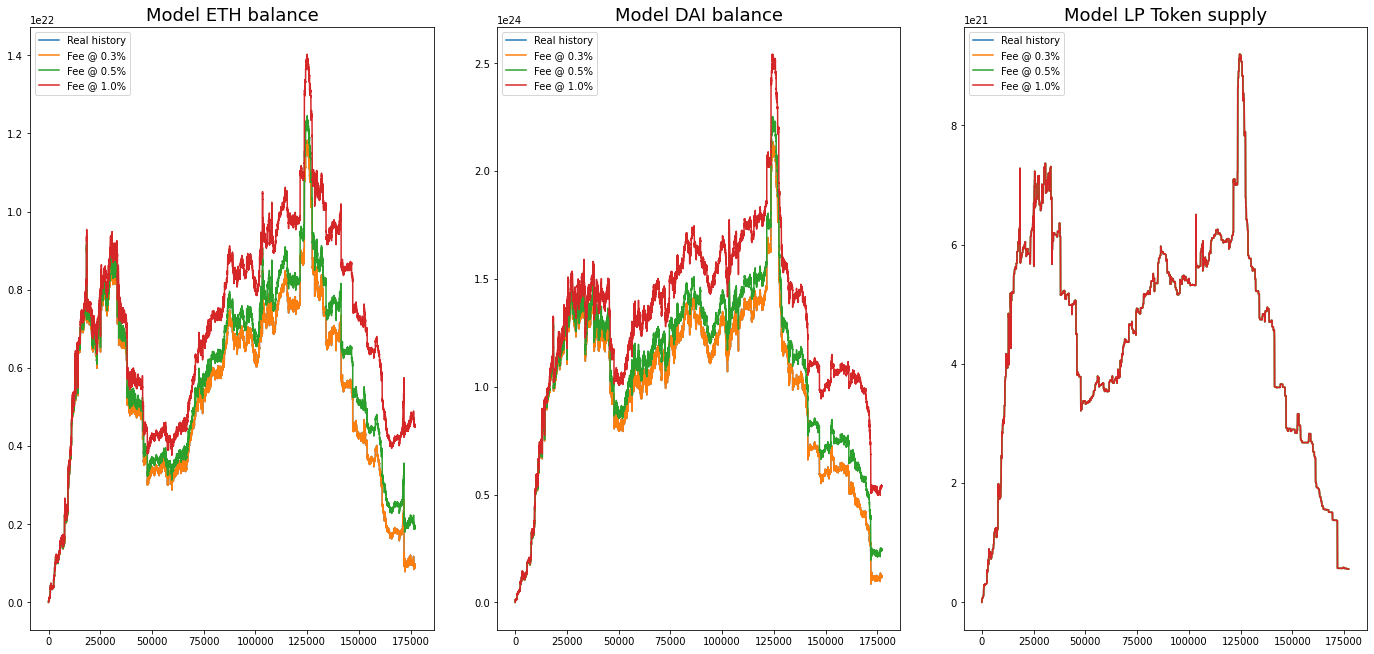

In [8]:
models = list()
for i in experiments['subset'].unique():
    models.append(experiments.loc[experiments['subset']==i,['dai_balance', 'eth_balance', 'lp_token_supply']])
    
for df in models:
    df.columns = ['model_dai_balance', 'model_eth_balance', 'model_lp_token_supply']
    df.reset_index(inplace=True)


nplots = len(set(fees))
ncols = 3

fig, axs = plt.subplots(ncols = ncols, nrows = 1, figsize=(20,10))

plt.close()

axs[0].plot(real_history['real_eth_balance'], label='Real history')
axs[1].plot(real_history['real_dai_balance'], label='Real history')
axs[2].plot(real_history['real_lp_token_supply'], label='Real history')
axs[0].set_title('Model ETH balance', fontsize=18)
axs[1].set_title('Model DAI balance', fontsize=18)
axs[2].set_title('Model LP Token supply', fontsize=18)
# axs[i][0].set_ylabel('conv_tolerance = {:.1f} %'.format(retail_tols[i]), fontsize=18)

for k in range(nplots):
    axs[0].plot(models[k]['model_eth_balance'],
                    label='Fee @ {:.1f}%'.format(fees[k]))
    axs[1].plot(models[k]['model_dai_balance'],
                    label='Fee @ {:.1f}%'.format(fees[k]))
    axs[2].plot(models[k]['model_lp_token_supply'],
                   label='Fee @ {:.1f}%'.format(fees[k]))

for j in range(ncols):
    axs[j].legend(loc='upper left')

fig.tight_layout(pad=4.0)
fig

Despite the simplifications, the outputs of the model are very similar to real data.

In [9]:
df = experiments

prev_dai = pd.Series([np.nan]).append(df['dai_balance'][:-1]).reset_index(drop=True)
prev_eth = pd.Series([np.nan]).append(df['eth_balance'][:-1]).reset_index(drop=True)
df['delta_dai'] = df['dai_balance'].diff()
df['delta_eth'] = df['eth_balance'].diff()
df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
df['volume'] = abs(df[df['istrade']]['delta_dai'])
df['volume'] = df['volume'].fillna(0)
df = df.drop(columns=['delta_dai','delta_eth','istrade'])

/var/folders/_l/_xt836490d739dw9hsf033tc0000gn/T/ipykernel_77988/3913025330.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prev_dai = pd.Series([np.nan]).append(df['dai_balance'][:-1]).reset_index(drop=True)
/var/folders/_l/_xt836490d739dw9hsf033tc0000gn/T/ipykernel_77988/3913025330.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prev_eth = pd.Series([np.nan]).append(df['eth_balance'][:-1]).reset_index(drop=True)


The success of Uniswap is directly associated to how much liquidity is being provided to the model. However, modelling the liquidity provider agent is a difficult task, as its decision making process tends to be very complex. Therefore, analyzing how much return a liquidity provider would have in Uniswap can be a more effective strategy, since higher returns mean more attractiveness for liquidity providers. To understand how a fee modification impacts the returns of the liquidity provider, we will use the following script:

In [42]:
def ExpMovingAverage(values, window):
        weights = np.exp(np.linspace(-1., 0., window))
        weights /= weights.sum()
        a =  np.convolve(values, weights, mode='full')[:len(values)]
        a[:window] = a[window]
        return a

plot_data = experiments.copy()
plot_data = plot_data[plot_data['eth_balance'] > 0]
plot_data = plot_data[plot_data['dai_balance'] > 0]
plot_data = plot_data[plot_data['lp_token_supply'] > 0]
print(len(plot_data))
plot_data[plot_data['eth_balance'] > 0][['dai_balance',
           'eth_balance',
           'lp_token_supply',
           'volume']] = plot_data[['dai_balance',
                                   'eth_balance',
                                   'lp_token_supply',
                                   'volume']]*1E-18
plot_data['eth_price_dai'] = plot_data['dai_balance'].divide(plot_data['eth_balance'])
plot_data['lp_token_price_dai'] = 2 * plot_data['dai_balance'].divide(plot_data['lp_token_supply'])

a = 0.5 * plot_data['eth_price_dai'][4] + 0.5 * plot_data['eth_price_dai']
plot_data['50_50_hodler_value'] = a.values

a = plot_data['50_50_hodler_value'].divide(plot_data['50_50_hodler_value'][4]) - 1
plot_data['50_50_hodler_return'] = a.values

a = plot_data['lp_token_price_dai'].divide(plot_data['lp_token_price_dai'][4]) - 1
plot_data['UNI_hodler_return'] = a.values

a = plot_data['eth_price_'].divide(plot_data['eth_price_dai'][4]) - 1
plot_data['ETH_hodler_return'] = a.values

plots = list()

for i in plot_data['subset'].unique():
    plots.append(plot_data[plot_data['subset'] == i])
for df in plots:
    df.reset_index(inplace=True)

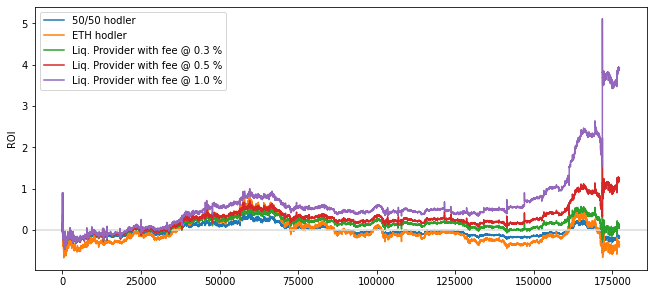

In [47]:
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
plt.rcParams['figure.facecolor'] = 'white'
from matplotlib import cm
import matplotlib.ticker as ticker

nplots = len(set(fees))
nrows = 1# len(set([]))
ncols = 1# len(set([]))

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(ncols*10,nrows*5))

plt.close()

axs.plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
axs.plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
axs.axhline(0, color='gainsboro')
axs.set_ylabel('ROI')
for k in range(nplots):
    ema = ExpMovingAverage(plots[k]['UNI_hodler_return'], 1)
    axs.plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[k]))

axs.legend(loc='upper left')

fig.set_facecolor('white')
fig.tight_layout(pad=4.0)
fig

## Conclusion

In this notebook, we have illustrated how to create a cadCAD model that takes in real data and replicates the mechanics of a real world smart contract extremely acurately by translating the smart contract code into python code. We enforce best practices for cadCAD modeling, and analyze our simulation data against the real data.

As future work proposals, we see that the liquidity provider behavior can be better explored and its return can be analyzed further. A good way to do that is to represent the retail tolerance parameter as a probability distribution. In this way, Monte Carlo runs can be used to create stochastic analysis.

Besides that, when usingt he arbitrage trader profit function, the model shows results that differ from Uniswap historical data. Because of that, this behavior wasn't taken into account for the return results shown before, and further analyses on this agent's behavior might help to increase its accuracy.